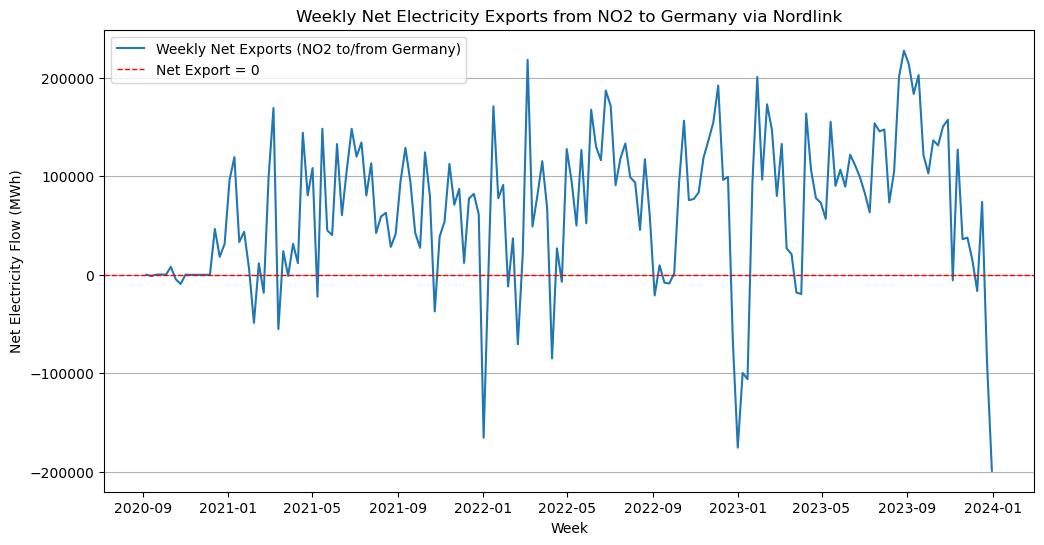

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Load and combine data
# ---
# Load all PhysicalFlows datasets from the directory using glob, then concatenate them into a single DataFrame.
# This approach allows us to work with all data at once, regardless of how many CSV files are present.
physical_flows_df = pd.concat(
    (pd.read_csv(file, delimiter="\t", encoding='utf-8') for file in glob.glob("./data/PhysicalFlows_12.1.G/*.csv")),
    ignore_index=True
)

# Convert DateTime column
# ---
# Convert the 'DateTime' column to datetime format for easier manipulation, enabling time-based operations.
physical_flows_df['DateTime'] = pd.to_datetime(physical_flows_df['DateTime'])

# Filter data to focus on Norway and Germany
# ---
# Apply a mask to select only the rows where the electricity flow is between NO2 (Norway) and DE_LU (Germany).
mask = ((physical_flows_df['InMapCode'] == 'NO2') & (physical_flows_df['OutMapCode'] == 'DE_LU')) | \
       ((physical_flows_df['InMapCode'] == 'DE_LU') & (physical_flows_df['OutMapCode'] == 'NO2'))
filtered_flows_df = physical_flows_df[mask].copy()

# Calculate net export
# ---
# Define net export as the difference between exports from NO2 to DE_LU and imports from DE_LU to NO2.
filtered_flows_df['FlowDirection'] = filtered_flows_df.apply(
    lambda row: 1 if row['OutMapCode'] == 'NO2' else -1, axis=1
)
filtered_flows_df['NetFlow'] = filtered_flows_df['FlowValue'] * filtered_flows_df['FlowDirection']

# Set DateTime as index for easier resampling
filtered_flows_df.set_index('DateTime', inplace=True)

# Resample data by week and calculate net exports
weekly_net_exports = filtered_flows_df['NetFlow'].resample('W').sum()

# Create a line plot to visualize weekly net exports
# ---
# Plot the weekly net exports of electricity between NO2 and Germany.
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_net_exports.index, weekly_net_exports.values, label='Weekly Net Exports (NO2 to/from Germany)')
ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Net Export = 0')
ax.set_xlabel('Week')
ax.set_ylabel('Net Electricity Flow (MWh)')
ax.set_title('Weekly Net Electricity Exports from NO2 to Germany via Nordlink')
ax.legend()
ax.grid(axis='y')

# Save and display the plot
fig.savefig("./weekly_net_exports_task4.png")
plt.show()

# Conclusion
# ---
# The line plot illustrates the weekly net exports of electricity between NO2 and Germany via the Nordlink cable.
# Periods where the net export is negative indicate weeks in which NO2 imported more electricity from Germany than it exported.
# The red horizontal line at y=0 helps visualize these periods more clearly.
